In [29]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from sklearn.utils.class_weight import compute_class_weight
import tensorflow.keras.backend as K

In [30]:
# Load the model
model_path = '/kaggle/input/restmodel/resnet50_model (1).h5'
model = load_model(model_path)

# Define data directories
train_data_dir = '/kaggle/input/misahubdataset/Dataset/training'
validation_data_dir = '/kaggle/input/misahubdataset/Dataset/validation'


In [31]:
# Data augmentation for training data
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

# Only rescale for validation data
validation_datagen = ImageDataGenerator(rescale=1./255)

# Create generators
train_generator = train_datagen.flow_from_directory(
    train_data_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical'
)

validation_generator = validation_datagen.flow_from_directory(
    validation_data_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical'
)


Found 37607 images belonging to 10 classes.
Found 16132 images belonging to 10 classes.


In [4]:
# Check if GPU is available
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
    except RuntimeError as e:
        print(e)

# Image Data Generators for training and validation
train_datagen = ImageDataGenerator(
    rescale=1.0/255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

val_datagen = ImageDataGenerator(rescale=1.0/255)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(224, 224),  # ResNet50 input size
    batch_size=32,
    class_mode='categorical'  # Adjust if binary classification
)

validation_generator = val_datagen.flow_from_directory(
    val_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical'  # Adjust if binary classification
)

# Load ResNet50 model without the top layer
base_model = ResNet50(weights='/kaggle/input/restnet/resnet50_weights_tf_dim_ordering_tf_kernels_notop.h5', include_top=False, input_shape=(224, 224, 3))


# Unfreeze all layers
for layer in base_model.layers:
    layer.trainable = True

Found 37607 images belonging to 10 classes.
Found 16132 images belonging to 10 classes.


In [5]:
# Add custom top layers
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
predictions = Dense(train_generator.num_classes, activation='softmax')(x)  # Adjust output based on classification

model = Model(inputs=base_model.input, outputs=predictions)

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // train_generator.batch_size,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // validation_generator.batch_size,
    epochs=10  # Adjust number of epochs as needed
)

# Save the model
model.save('resnet50_model.h5')

Epoch 1/10


/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
I0000 00:00:1729260831.288031     139 service.cc:145] XLA service 0x7b13b8002e70 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1729260831.288086     139 service.cc:153]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1729260831.288092     139 service.cc:153]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5
I0000 00:00:1729260857.018021     139 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'loop_add_subtract_fusion_30', 20 bytes spill stores, 20 bytes spill loads

I0000 00:00:1729260857.061

 283/1175 ━━━━━━━━━━━━━━━━━━━━ 10:10 684ms/step - accuracy: 0.7568 - loss: 1.2024

I0000 00:00:1729261050.246925     139 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'input_add_reduce_fusion_48', 168 bytes spill stores, 168 bytes spill loads
ptxas warning : Registers are spilled to local memory in function 'input_reduce_fusion', 28 bytes spill stores, 28 bytes spill loads
ptxas warning : Registers are spilled to local memory in function 'loop_add_subtract_fusion_23', 20 bytes spill stores, 20 bytes spill loads



1175/1175 ━━━━━━━━━━━━━━━━━━━━ 930s 739ms/step - accuracy: 0.7641 - loss: 0.9556 - val_accuracy: 0.7626 - val_loss: 0.7713
Epoch 2/10
   1/1175 ━━━━━━━━━━━━━━━━━━━━ 5:37 288ms/step - accuracy: 0.7500 - loss: 0.8969

/opt/conda/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


1175/1175 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.7500 - loss: 0.8969 - val_accuracy: 0.7500 - val_loss: 0.5870
Epoch 3/10
1175/1175 ━━━━━━━━━━━━━━━━━━━━ 595s 487ms/step - accuracy: 0.7939 - loss: 0.6372 - val_accuracy: 0.7148 - val_loss: 0.9483
Epoch 4/10
1175/1175 ━━━━━━━━━━━━━━━━━━━━ 0s 36us/step - accuracy: 0.8438 - loss: 0.3967 - val_accuracy: 0.7500 - val_loss: 1.2663
Epoch 5/10
1175/1175 ━━━━━━━━━━━━━━━━━━━━ 573s 485ms/step - accuracy: 0.8353 - loss: 0.5025 - val_accuracy: 0.5551 - val_loss: 1.4009
Epoch 6/10
1175/1175 ━━━━━━━━━━━━━━━━━━━━ 0s 38us/step - accuracy: 0.8750 - loss: 0.3573 - val_accuracy: 0.5000 - val_loss: 2.4392
Epoch 7/10
1175/1175 ━━━━━━━━━━━━━━━━━━━━ 575s 486ms/step - accuracy: 0.8555 - loss: 0.4330 - val_accuracy: 0.8335 - val_loss: 0.5620
Epoch 8/10
1175/1175 ━━━━━━━━━━━━━━━━━━━━ 0s 38us/step - accuracy: 0.8750 - loss: 0.6119 - val_accuracy: 1.0000 - val_loss: 0.0635
Epoch 9/10
1175/1175 ━━━━━━━━━━━━━━━━━━━━ 573s 485ms/step - accuracy: 0.8681 - loss: 0

In [11]:
import numpy as np

# Load and preprocess test images
test_datagen = ImageDataGenerator(rescale=1./255)  # Rescale the images (same as for training)

# Since there is only one folder "Images", the flow_from_directory will assume it's a single class
# We set class_mode to None since the test data has no labels
test_generator = test_datagen.flow_from_directory(
    '/kaggle/input/testing/Testing set',  # Path to your test dataset
    target_size=(224, 224),               # Image size should match the input size of the model
    batch_size=32,                        # Adjust the batch size as needed
    class_mode=None,                      # No labels provided in the test set
    shuffle=False                         # Do not shuffle, so predictions align with file order
)

# Use the model to predict on test data
predictions = model.predict(test_generator, steps=test_generator.samples // test_generator.batch_size)

# Convert the predicted probabilities to class indices
predicted_class_indices = np.argmax(predictions, axis=1)

# Map class indices to labels (based on training data)
labels = (train_generator.class_indices)
labels = dict((v,k) for k,v in labels.items())  # Invert the dictionary
predicted_labels = [labels[k] for k in predicted_class_indices]

# Print the predicted labels
print(predicted_labels)


Found 4385 images belonging to 1 classes.
137/137 ━━━━━━━━━━━━━━━━━━━━ 10s 70ms/step
['Normal', 'Normal', 'Worms', 'Normal', 'Angioectasia', 'Normal', 'Worms', 'Normal', 'Normal', 'Normal', 'Normal', 'Normal', 'Normal', 'Normal', 'Ulcer', 'Normal', 'Normal', 'Normal', 'Normal', 'Normal', 'Normal', 'Bleeding', 'Normal', 'Normal', 'Normal', 'Normal', 'Normal', 'Normal', 'Normal', 'Normal', 'Erythema', 'Normal', 'Normal', 'Worms', 'Normal', 'Worms', 'Normal', 'Worms', 'Normal', 'Foreign Body', 'Normal', 'Normal', 'Normal', 'Normal', 'Normal', 'Worms', 'Normal', 'Normal', 'Normal', 'Normal', 'Normal', 'Normal', 'Normal', 'Normal', 'Normal', 'Normal', 'Normal', 'Normal', 'Normal', 'Normal', 'Normal', 'Normal', 'Angioectasia', 'Worms', 'Worms', 'Normal', 'Worms', 'Ulcer', 'Normal', 'Normal', 'Normal', 'Normal', 'Normal', 'Worms', 'Normal', 'Normal', 'Normal', 'Normal', 'Worms', 'Normal', 'Worms', 'Normal', 'Normal', 'Normal', 'Normal', 'Normal', 'Ulcer', 'Normal', 'Normal', 'Normal', 'Normal

In [17]:
# Trim to the smaller of the two lengths
min_length = min(len(filenames), len(predicted_labels))
filenames = filenames[:min_length]
predicted_labels = predicted_labels[:min_length]
results = pd.DataFrame({
    "Filename": filenames,
    "Predicted Label": predicted_labels
})
results.to_csv('predictions.csv', index=False)
print("Predictions saved to predictions.csv")


Predictions saved to predictions.csv


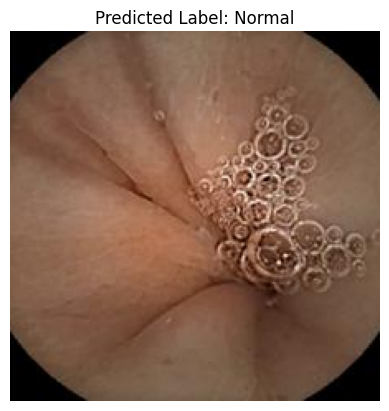

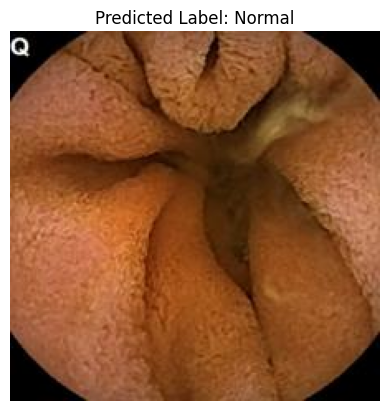

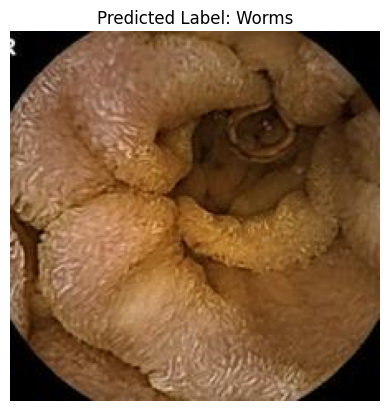

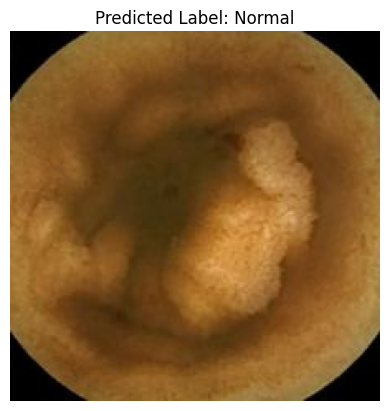

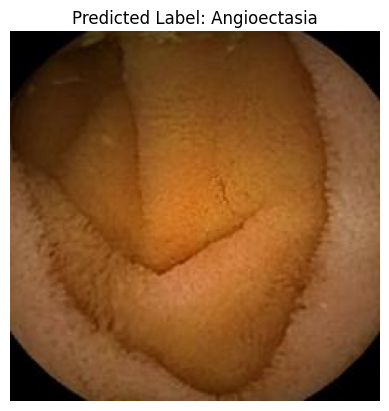

In [18]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

# Number of samples to visualize
num_samples = 5

# Visualize the first 'num_samples' images and their predicted labels
for i in range(num_samples):
    img_path = test_generator.filepaths[i]
    img = mpimg.imread(img_path)
    plt.imshow(img)
    plt.title(f"Predicted Label: {predicted_labels[i]}")
    plt.axis('off')
    plt.show()


In [23]:
# Get predictions for the validation data
val_steps = validation_generator.samples // validation_generator.batch_size + 1  # Add 1 to cover all samples
val_predictions = model.predict(validation_generator, steps=val_steps)

# Convert predicted probabilities to class indices
val_predicted_class_indices = np.argmax(val_predictions, axis=1)

# Get the actual labels from the validation generator
actual_labels = validation_generator.classes  # This will give you the true labels

# Debugging: Print the counts of actual and predicted labels
print(f"Actual labels count: {len(actual_labels)}")
print(f"Predicted labels count: {len(val_predicted_class_indices)}")

# Calculate balanced accuracy only if lengths match
if len(actual_labels) == len(val_predicted_class_indices):
    balanced_accuracy = balanced_accuracy_score(actual_labels, val_predicted_class_indices)
    print(f"Balanced Accuracy: {balanced_accuracy:.4f}")
else:
    print("Warning: The number of actual labels and predicted labels do not match!")


505/505 ━━━━━━━━━━━━━━━━━━━━ 39s 78ms/step
Actual labels count: 16132
Predicted labels count: 16132
Balanced Accuracy: 0.6357


In [28]:
import os

# Define the path to your training and validation directories
base_dataset_dir = '/kaggle/input/misahubdataset/Dataset/'  # Replace with your dataset path
train_dir = os.path.join(base_dataset_dir, 'training')
val_dir = os.path.join(base_dataset_dir, 'validation')

# Function to count image folders in a given directory
def count_image_folders(directory):
    # List all items in the directory and filter for directories only
    folders = [d for d in os.listdir(directory) if os.path.isdir(os.path.join(directory, d))]
    return len(folders), folders

# Count image folders in training and validation directories
train_folder_count, train_folders = count_image_folders(train_dir)
val_folder_count, val_folders = count_image_folders(val_dir)

# Print the results
print(f"Number of image folders in 'training': {train_folder_count}")
print("Folders:", train_folders)
print(f"Number of image folders in 'validation': {val_folder_count}")
print("Folders:", val_folders)


Number of image folders in 'training': 10
Folders: ['Erythema', 'Foreign Body', 'Bleeding', 'Lymphangiectasia', 'Normal', 'Angioectasia', 'Erosion', 'Ulcer', 'Polyp', 'Worms']
Number of image folders in 'validation': 10
Folders: ['Erythema', 'Foreign Body', 'Bleeding', 'Lymphangiectasia', 'Normal', 'Angioectasia', 'Erosion', 'Ulcer', 'Polyp', 'Worms']


In [29]:
import pandas as pd

# Load the predictions CSV file
predictions_df = pd.read_csv('predictions.csv')

# Count the occurrences of each predicted label
label_counts = predictions_df['Predicted Label'].value_counts()

# Print the counts for each label
print("Counts of predicted labels:")
print(label_counts)


Counts of predicted labels:
Predicted Label
Normal              3530
Worms                332
Bleeding             163
Ulcer                149
Polyp                 64
Foreign Body          52
Erosion               32
Erythema              26
Angioectasia          19
Lymphangiectasia      17
Name: count, dtype: int64
